In [1]:
%matplotlib inline  
import librosa
import librosa.display
import IPython
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
audio_data = 'Noita__2024-11-11__20-12-36_trim_audio.mp3'
y, sr = librosa.load(audio_data)

Функция load считывает аудио-файл в виде временного рядя. Где, sr обозначает sample_rate.
Time series (временной ряд) представлен массивом.
sample_rate — это количество сэмплов на секунду аудио.
По умолчанию звук микшируется в моно. Но его можно передискретизировать во время загрузки до 22050 Гц. Это делается с помощью дополнительных параметров в функции librosa.load

In [3]:
print(type(y), type(sr))
print(y.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(173534,) 22050


С помощью IPython.display можно проигрывать аудио в Jupyter Notebook, а с помощью display.waveshow формируются звуковые волны и мы можем посмотреть, как выглядит звук:

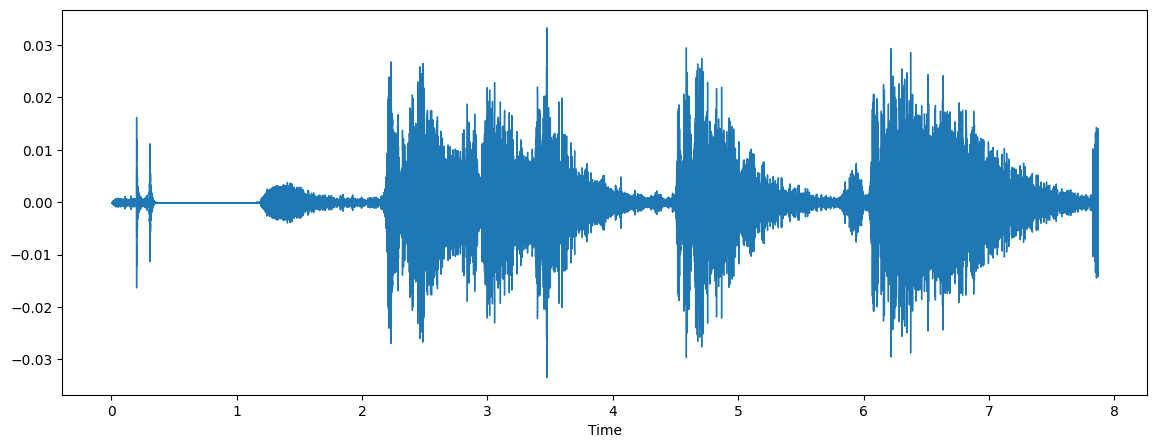

In [4]:
import IPython.display as ipd
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
ipd.Audio(audio_data)

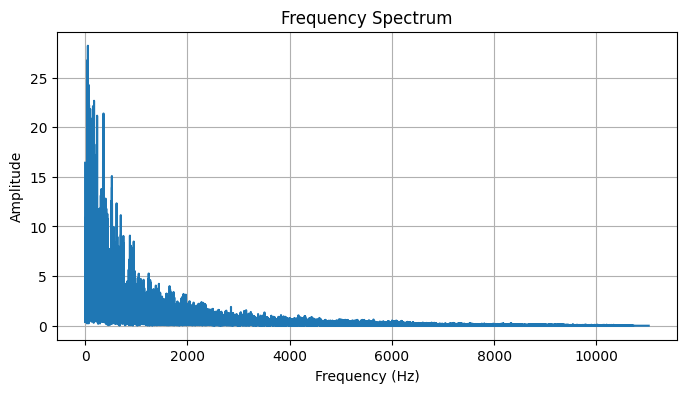

In [5]:
# Compute the FFT of the waveform
from scipy.fft import fft
spectrum = fft(y)
 
# Frequency bins
frequencies = np.fft.fftfreq(len(spectrum), 1 / sr)
 
# Plot the frequency spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(spectrum[:len(spectrum)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Harmonic + Percussive')

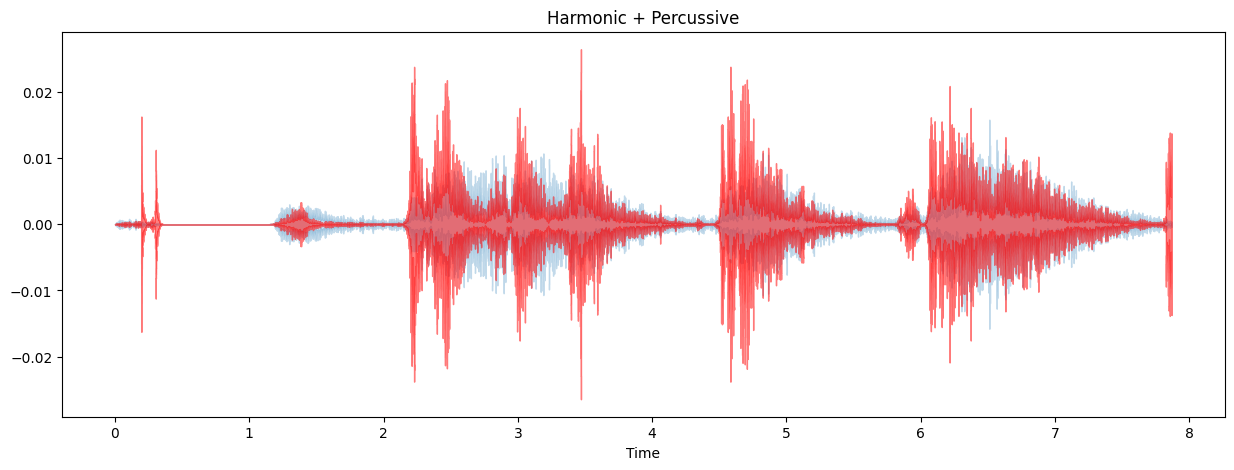

In [6]:
# Seperation of Harmonic and Percussive Signals
y_harmonic, y_percussive = librosa.effects.hpss(y)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveshow(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')

Извлечение признаков из аудиофайла
У сэмпла есть несколько важных признаков. Есть фундаментальное понятие ритма в некоторых формах, а остальные либо имеют свою нюансы, либо связаны:

Темп: скорость, с которой паттерны повторяются. Темп измеряется в битах в минуту (BPM). Если у музыки 120 BPM, это значит, что каждую минуту в ней 120 битов (ударов).
Бит: отрезок времени. Это ритм, выстукиваемый в песне. Так, в одном такте 4 бита, например.
Такт: логичное деление битов. Обычно в такте 3 или 4 бита, хотя возможны и другие варианты.
Интервал: в программах для редактирования чаще всего встречаются интервалы. Обычно есть последовательность нот, например, 8 шестнадцатых одинаковой длины. Обычно интервал — 8 нот, триплеты или четверные.
Ритм: список музыкальных звуков. Все ноты и являются ритмом.

Мел-кепстральные коэффициенты (MFCC)

# В чём ошибка 
Ошибка заключается в том что функция sns.barplot() ожидает получить X и Y для указаний данных по осям.

# Beat Extraction
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,sr=sr)
print('Detected Tempo: '+str(tempo)+ ' beats/min')
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_time_diff=np.ediff1d(beat_times)
beat_nums = np.arange(1, np.size(beat_times))

print(beat_nums)

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.set_ylabel("Time difference (s)")
ax.set_xlabel("Beats")
g=sns.barplot(x=beat_nums, y=beat_time_diff, hue=beat_nums, legend=False, palette="BuGn_d", ax=ax)
g=g.set(xticklabels=[])

Text(0.5, 1.0, 'MFCC')

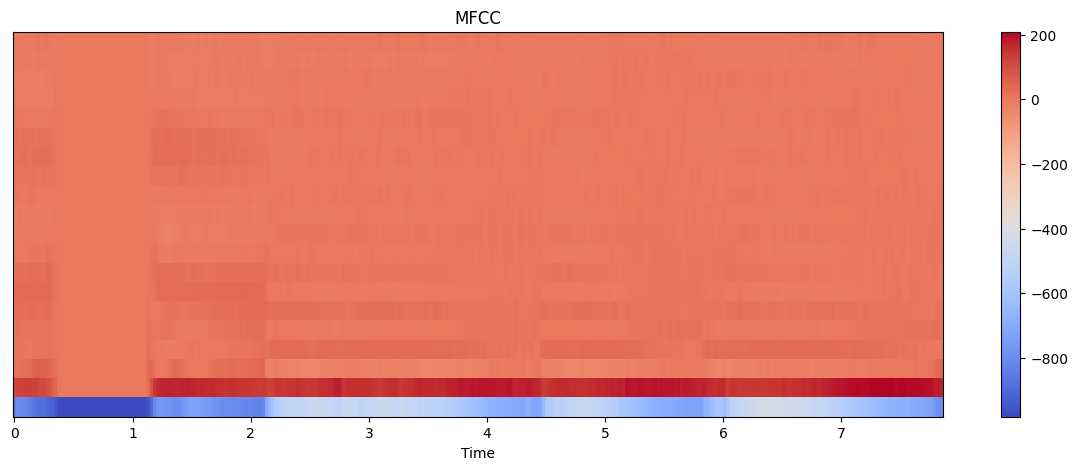

In [7]:
# Calculate MFCCs
mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=20)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

In [8]:
mfccs

array([[-8.49702881e+02, -7.99773315e+02, -7.99654907e+02, ...,
        -7.90703491e+02, -7.92571228e+02, -8.02395081e+02],
       [ 1.12408310e+02,  1.24931458e+02,  1.24375214e+02, ...,
         1.77524399e+02,  1.82046783e+02,  1.76427109e+02],
       [ 1.68121071e+01,  1.25002918e+01,  1.81863232e+01, ...,
         3.27169304e+01,  3.95067215e+01,  4.38187904e+01],
       ...,
       [-1.16052265e+01, -1.43397045e+01, -1.11791611e+01, ...,
        -3.87445927e+00, -2.24117994e+00, -1.16821587e-01],
       [-7.03681278e+00, -9.15215492e+00, -7.99965668e+00, ...,
        -2.64254713e+00,  1.77799332e+00,  2.62067652e+00],
       [-2.73790002e+00, -3.94176507e+00, -2.71678877e+00, ...,
        -2.94042063e+00, -2.75515652e+00, -1.83988261e+00]], dtype=float32)

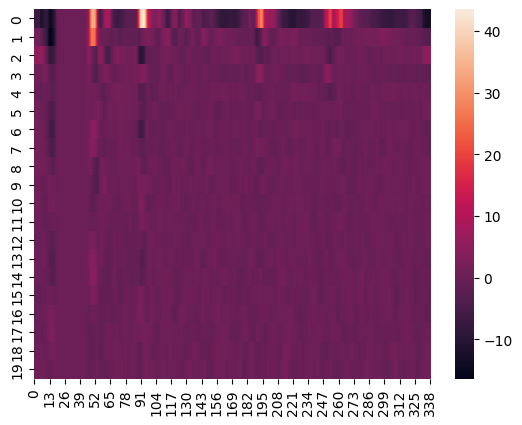

In [9]:
mfcc_delta = librosa.feature.delta(mfccs)
sns.heatmap(mfcc_delta)
plt.show()

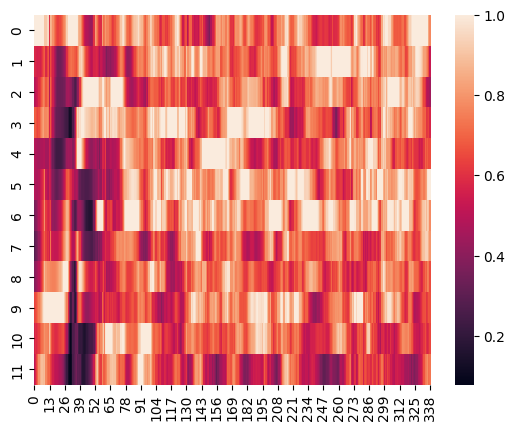

In [10]:
# нормализация в хромограмму
chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)
sns.heatmap(chromagram)
plt.show()

Спектрограмма

Спектрограмма - это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, 
присутствующих в форме волны. Обычно изображается в виде тепловой карты. .stft() преобразует данные в кратковременное преобразование 
Фурье. С помощью STFT можно определить амплитуду различных частот, воспроизводимых в данный момент времени аудиосигнала.

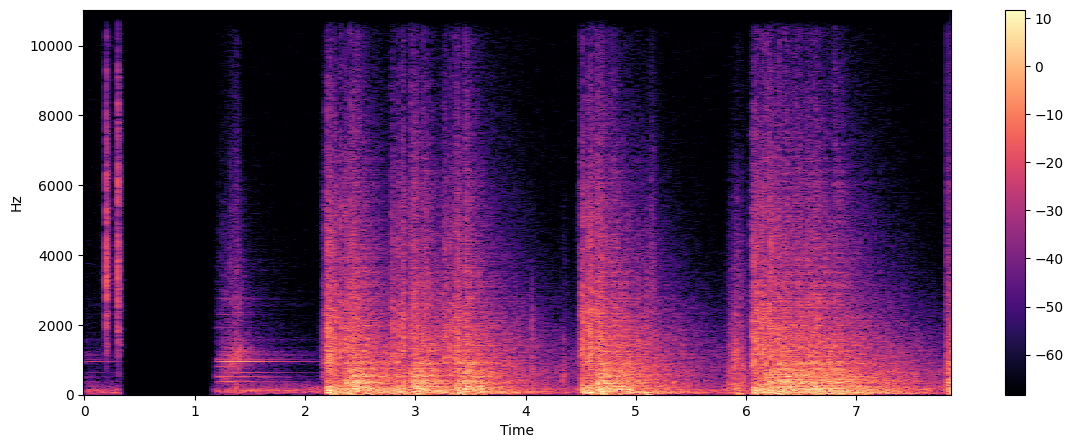

In [11]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

Спектральный центроид - Spectral Centroid.

Указывает, на какой частоте сосредоточена энергия спектра или, другими словами, указывает, где расположен “центр масс” для звука. 
librosa.feature.spectral_centroid вычисляет спектральный центроид для каждого фрейма в сигнале:

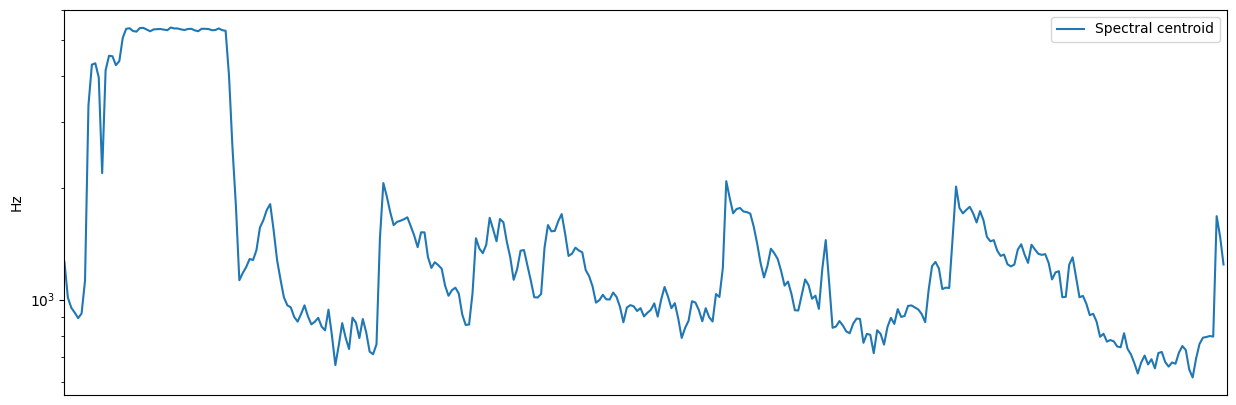

In [12]:
# Spectral Centroid
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.subplot(1, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()

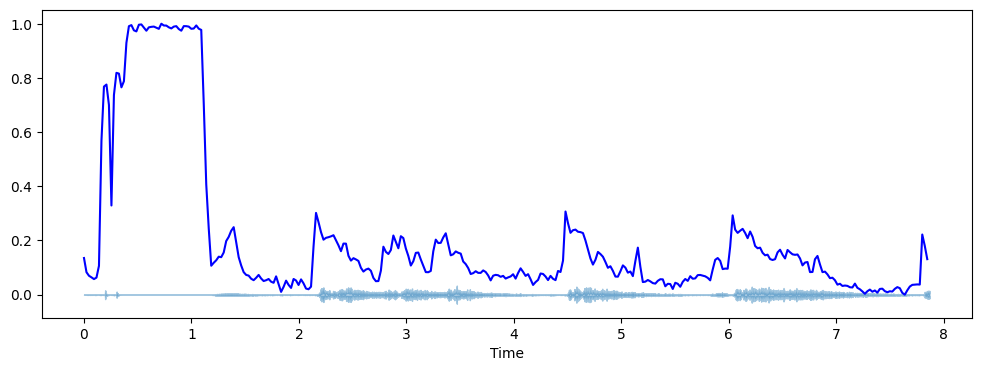

In [13]:
import sklearn
spectral_centroids = cent[0]
spectral_centroids.shape

# Вычисление временной переменной для визуализации
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Нормализация спектрального центроида для визуализации
def normalize(y, axis=0):
    return sklearn.preprocessing.minmax_scale(y, axis=axis)
# Построение спектрального центроида вместе с формой волны
librosa.display.waveshow(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

# Что такое гармоническая и перкуссионная части сигнала, зачем они нужны?
Гармоническая часть сигнала — это регулярные, периодические звуки, в виде синусоидальной волны, связанные с музыкальными тонами и мелодиями (например, звук гитары или пианино). Она важна для анализа мелодий, определения тональности и синтеза звуков инструментов.

Перкуссионная часть — это короткие, резкие, непериодические звуки, связанные с ритмом и ударными (например, барабаны). Она важна для анализа ритма, темпа и создания ритмических эффектов.